<a href="https://colab.research.google.com/github/Mauricius99/Mau_1988/blob/main/MVP_Classificacao_BreastCancer_relatorio_completo_PLUS.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# MVP — Classificação Binária (Breast Cancer, sklearn)

**Autor:** Maurícius Nascimento Menezes  
**Data:** 2025-09-18

**Matrícula: **4052025000102**

**Dataset: **sklearn.datasets.load_breast_cancer()**

Este notebook segue o checklist de um **MVP supervisionado** (classificação) com:
- Carga, entendimento e **qualidade** dos dados
- **EDA** resumida
- Definição de **target** e variáveis; **divisão** dos dados
- **Pipeline** de pré-processamento + tratamento
- **Baseline** e **modelos candidatos**
- Treino e **avaliação rápida** (CV)
- **Validação e Otimização de Hiperparâmetros**
- **Avaliação final**, análise de erros e limitações
- **Engenharia de atributos** (detalhe)
- **Boas práticas**, reprodutibilidade e rastreabilidade
- **Conclusões e próximos passos**


## 0) Reprodutibilidade e Ambiente

- Seeds fixos (`random_state=42`) em *splits* e modelos quando aplicável.  
- Versões do ambiente são impressas abaixo para rastreabilidade.  
- Todos os passos críticos estão encapsulados em **pipelines** (evitar vazamento de dados).

In [1]:
#@title Imports e configuração do ambiente
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from time import time

import sys, platform, sklearn
from sklearn.datasets import load_breast_cancer
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_validate, RandomizedSearchCV
from sklearn.preprocessing import StandardScaler, FunctionTransformer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import (accuracy_score, precision_score, recall_score, f1_score,
                             roc_auc_score, roc_curve, precision_recall_curve, confusion_matrix,
                             ConfusionMatrixDisplay, classification_report)
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.feature_selection import SelectKBest, mutual_info_classif, SelectFromModel

GLOBAL_SEED = 42
np.random.seed(GLOBAL_SEED)

print("Python:", sys.version.split()[0])
print("NumPy:", np.__version__)
print("Pandas:", pd.__version__)
print("scikit-learn:", sklearn.__version__)
print("Plataforma:", platform.platform())


Python: 3.12.11
NumPy: 2.0.2
Pandas: 2.2.2
scikit-learn: 1.6.1
Plataforma: Linux-6.1.123+-x86_64-with-glibc2.35


## 1) Dados: carga, entendimento e qualidade

**Fonte:** `sklearn.datasets.load_breast_cancer()`  
**Amostras:** 569 | **Atributos numéricos:** 30 | **Target:** binário

Checagens de **qualidade**:
- *Missing values* (por coluna)
- Duplicatas
- Estatísticas descritivas
- *Quick* **outlier check** por Z-score (contagem > 3 desvios) — diagnóstico leve


In [4]:
#@title Carga dos dados e checagens de qualidade
data = load_breast_cancer()
X = pd.DataFrame(data.data, columns=data.feature_names)
y_raw = pd.Series(data.target, name="target")  # 0=malignant, 1=benign no sklearn

# Mapeamos para 1=malignant, 0=benign para priorizar recall de positivos (malignos)
y = y_raw.apply(lambda v: 1 if data.target_names[v] == "malignant" else 0)

print("Shape:", X.shape)
display(X.head(5))

# Qualidade
missing_total = X.isna().sum().sum()
print("Total de valores faltantes:", missing_total)
dup_total = X.duplicated().sum()
print("Total de linhas duplicadas:", dup_total)

desc = X.describe().T
display(desc)

# Outlier quick check via z-score
zs = (X - X.mean())/X.std(ddof=0)
outlier_counts = (np.abs(zs) > 3).sum()
print("Contagem de valores além de 3 desvios por coluna:")
display(outlier_counts.sort_values(ascending=False).head(10))


Shape: (569, 30)


,mean radius,mean texture,mean perimeter,mean area,mean smoothness,mean compactness,mean concavity,mean concave points,mean symmetry,mean fractal dimension,...,worst radius,worst texture,worst perimeter,worst area,worst smoothness,worst compactness,worst concavity,worst concave points,worst symmetry,worst fractal dimension
0,17.99,10.38,122.80,1001.0,0.11840,0.27760,0.3001,0.14710,0.2419,0.07871,...,25.38,17.33,184.60,2019.0,0.1622,0.6656,0.7119,0.2654,0.4601,0.11890
1,20.57,17.77,132.90,1326.0,0.08474,0.07864,0.0869,0.07017,0.1812,0.05667,...,24.99,23.41,158.80,1956.0,0.1238,0.1866,0.2416,0.1860,0.2750,0.08902
2,19.69,21.25,130.00,1203.0,0.10960,0.15990,0.1974,0.12790,0.2069,0.05999,...,23.57,25.53,152.50,1709.0,0.1444,0.4245,0.4504,0.2430,0.3613,0.08758
3,11.42,20.38,77.58,386.1,0.14250,0.28390,0.2414,0.10520,0.2597,0.09744,...,14.91,26.50,98.87,567.7,0.2098,0.8663,0.6869,0.2575,0.6638,0.17300
4,20.29,14.34,135.10,1297.0,0.10030,0.13280,0.1980,0.10430,0.1809,0.05883,...,22.54,16.67,152.20,1575.0,0.1374,0.2050,0.4000,0.1625,0.2364,0.07678


Total de valores faltantes: 0
Total de linhas duplicadas: 0


,count,mean,std,min,25%,50%,75%,max
mean radius,569.0,14.127292,3.524049,6.981000,11.700000,13.370000,15.780000,28.11000
mean texture,569.0,19.289649,4.301036,9.710000,16.170000,18.840000,21.800000,39.28000
mean perimeter,569.0,91.969033,24.298981,43.790000,75.170000,86.240000,104.100000,188.50000
mean area,569.0,654.889104,351.914129,143.500000,420.300000,551.100000,782.700000,2501.00000
mean smoothness,569.0,0.096360,0.014064,0.052630,0.086370,0.095870,0.105300,0.16340
mean compactness,569.0,0.104341,0.052813,0.019380,0.064920,0.092630,0.130400,0.34540
mean concavity,569.0,0.088799,0.079720,0.000000,0.029560,0.061540,0.130700,0.42680
mean concave points,569.0,0.048919,0.038803,0.000000,0.020310,0.033500,0.074000,0.20120
mean symmetry,569.0,0.181162,0.027414,0.106000,0.161900,0.179200,0.195700,0.30400
mean fractal dimension,569.0,0.062798,0.007060,0.049960,0.057700,0.061540,0.066120,0.09744


Contagem de valores além de 3 desvios por coluna:


,0
compactness error,12
symmetry error,11
worst area,10
fractal dimension error,10
worst compactness,10
mean compactness,9
texture error,9
worst fractal dimension,9
worst symmetry,9
mean concavity,9


## 2) Análise Exploratória Resumida (EDA)

- **Balanceamento das classes**
- **Correlação** entre atributos (mapa de calor com `matplotlib`)
- Distribuições rápidas de algumas *features* relevantes


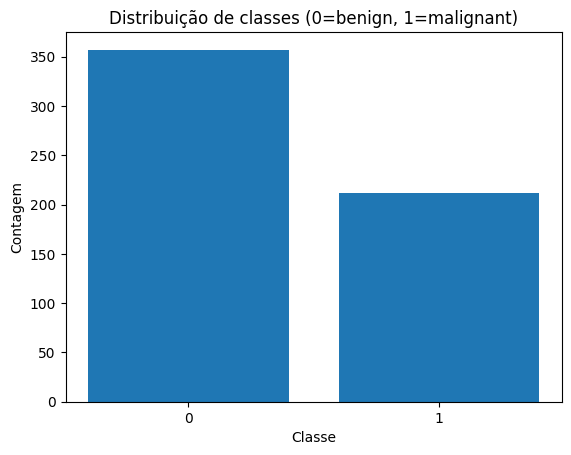

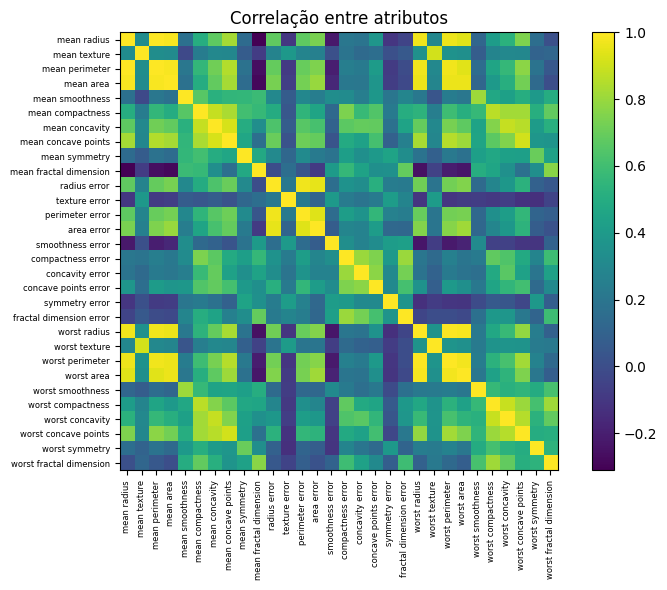

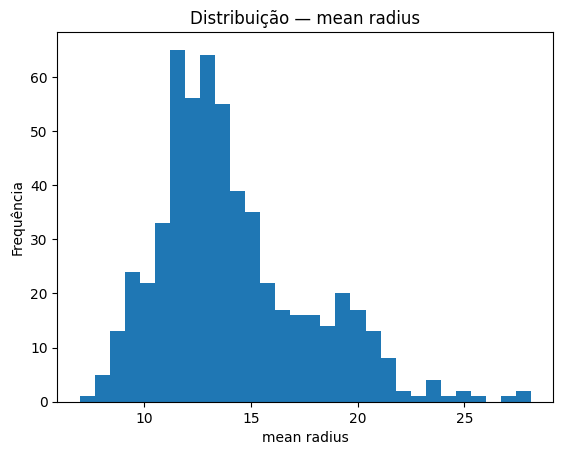

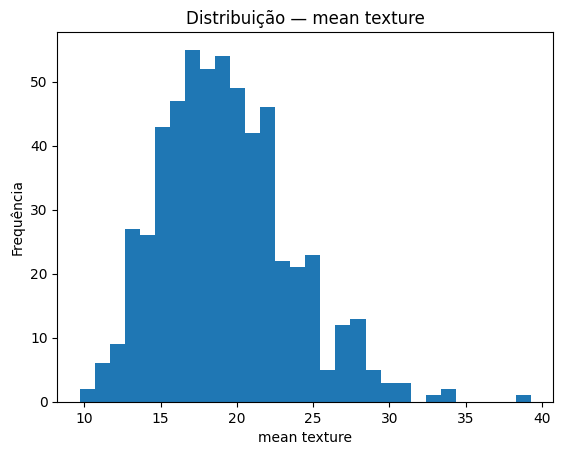

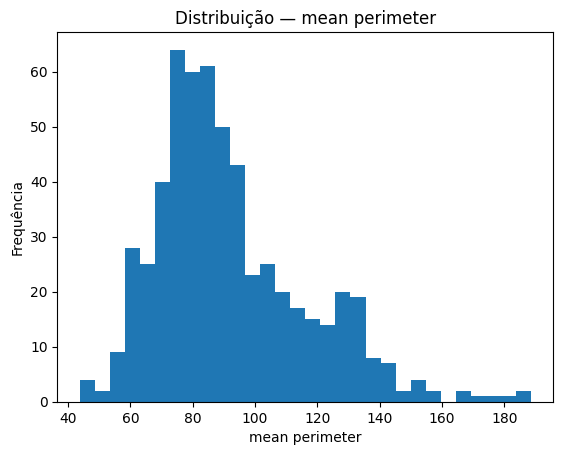

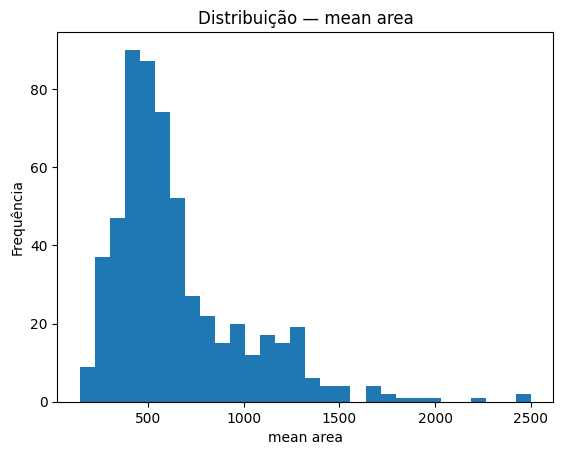

In [5]:
#@title EDA: balanceamento, correlação e distribuições
# Balanceamento
class_counts = y.value_counts().sort_index()
plt.figure()
plt.bar(class_counts.index.astype(str), class_counts.values)
plt.title("Distribuição de classes (0=benign, 1=malignant)")
plt.xlabel("Classe"); plt.ylabel("Contagem")
plt.show()

# Correlação (matriz compacta para visualização)
corr = X.corr()
plt.figure(figsize=(8,6))
plt.imshow(corr, interpolation="nearest")
plt.title("Correlação entre atributos")
plt.colorbar()
plt.xticks(range(len(corr.columns)), corr.columns, rotation=90, fontsize=6)
plt.yticks(range(len(corr.columns)), corr.columns, fontsize=6)
plt.tight_layout()
plt.show()

# Distribuições de algumas features
sel_cols = ["mean radius", "mean texture", "mean perimeter", "mean area"]
for col in sel_cols:
    plt.figure()
    plt.hist(X[col], bins=30)
    plt.title(f"Distribuição — {col}")
    plt.xlabel(col); plt.ylabel("Frequência")
    plt.show()


## 3) Definição do Target, Variáveis e Divisão dos Dados

- **Target**: `1 = malignant`, `0 = benign`.  
- **Variáveis**: 30 atributos numéricos contínuos.  
- **Split**: holdout **estratificado** 80/20 (treino/teste). Validação com **StratifiedKFold (5 folds)**.  
- Justificativa da **CV**: dataset moderado; CV reduz variância da estimativa e permite comparar modelos com *fairness*.


In [6]:
#@title Split estratificado e CV
from sklearn.model_selection import StratifiedKFold, train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, stratify=y, random_state=GLOBAL_SEED
)

cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=GLOBAL_SEED)
print("Shapes — Treino:", X_train.shape, "| Teste:", X_test.shape)


Shapes — Treino: (455, 30) | Teste: (114, 30)


## 4) Tratamento de Dados e Pipeline de Pré-processamento

Transformações aplicadas **dentro da pipeline** (evita vazamento):
- `StandardScaler` para todas as *features* (modelos sensíveis à escala).
- **Opcional**: seleção de atributos (`SelectKBest` com MI ou `SelectFromModel` com L1).

In [8]:
#@title Definição do ColumnTransformer e Pipelines base
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline

num_features = list(X.columns)

preprocess = ColumnTransformer(
    transformers=[("num", Pipeline([("scaler", StandardScaler())]), num_features)],
    remainder="drop",
)


## 5) Baseline e Modelos Candidatos

**Baseline**: `DummyClassifier(strategy="stratified")`.  
**Candidatos**: `LogisticRegression`, `RandomForest`, `GradientBoosting`, `SVC (RBF)`, `KNN`.  
Todos encapsulados em *pipelines*. Justificativas:
- LR: interpretável e forte como baseline com *scaling*.
- RF/GBC: capturam não-linearidade e interações.
- SVC: fronteiras complexas com kernel RBF.
- KNN: método baseado em instâncias (sensível à escala e dimensionalidade).


In [9]:
#@title Instanciar modelos
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier

models = {
    "Dummy (stratified)": Pipeline([("prep", preprocess), ("clf", DummyClassifier(strategy="stratified", random_state=GLOBAL_SEED))]),
    "LogisticRegression": Pipeline([("prep", preprocess), ("clf", LogisticRegression(max_iter=700, random_state=GLOBAL_SEED))]),
    "RandomForest": Pipeline([("prep", preprocess), ("clf", RandomForestClassifier(n_estimators=300, random_state=GLOBAL_SEED))]),
    "GradientBoosting": Pipeline([("prep", preprocess), ("clf", GradientBoostingClassifier(random_state=GLOBAL_SEED))]),
    "SVC": Pipeline([("prep", preprocess), ("clf", SVC(kernel="rbf", probability=True, random_state=GLOBAL_SEED))]),
    "KNN": Pipeline([("prep", preprocess), ("clf", KNeighborsClassifier(n_neighbors=7))]),
}


## 6) Treino e Avaliação Rápida (Baseline vs. Candidatos)

Validação cruzada **estratificada (5-fold)** com métricas: Accuracy, Precision, Recall, F1 e ROC-AUC.


In [10]:
#@title Cross-validate rápido (tabela comparativa)
def cv_summary(pipe, X, y, cv):
    scoring = {"accuracy":"accuracy","precision":"precision","recall":"recall","f1":"f1","roc_auc":"roc_auc"}
    t0 = time()
    out = cross_validate(pipe, X, y, cv=cv, scoring=scoring, n_jobs=-1, return_train_score=False)
    elapsed = time()-t0
    row = {f"{k.replace('test_','')}_mean": out[k].mean() for k in out if k.startswith("test_")}
    row["fit_time_mean"] = out["fit_time"].mean()
    row["score_time_mean"] = out["score_time"].mean()
    row["cv_elapsed_s"] = elapsed
    return row

rows = []
for name, pipe in models.items():
    res = cv_summary(pipe, X_train, y_train, cv)
    res["model"] = name
    rows.append(res)

cv_table = pd.DataFrame(rows).sort_values("roc_auc_mean", ascending=False)
display(cv_table)


,accuracy_mean,precision_mean,recall_mean,f1_mean,roc_auc_mean,fit_time_mean,score_time_mean,cv_elapsed_s,model
1,0.973626,0.977143,0.952941,0.964048,0.995769,0.045852,0.096090,0.515314,LogisticRegression
4,0.971429,0.976946,0.947059,0.960987,0.994943,0.033218,0.030879,0.197764,SVC
3,0.967033,0.964631,0.947059,0.955284,0.990815,1.193364,0.036496,3.395843,GradientBoosting
2,0.960440,0.958381,0.935294,0.946148,0.987977,1.321941,0.117907,4.439630,RandomForest
5,0.969231,0.987868,0.929412,0.957474,0.985965,0.009966,0.049948,0.187883,KNN
0,0.556044,0.393333,0.347059,0.368750,0.513880,0.017922,0.052633,4.531158,Dummy (stratified)


## 7) Validação e Otimização de Hiperparâmetros

Otimizamos **RF**, **GBC** e **SVC** via `RandomizedSearchCV` (refit por `roc_auc`) dentro de CV estratificada.


In [ ]:
#@title RandomizedSearchCV
rf_space = {
    "clf__n_estimators": [100,200,300,500,800],
    "clf__max_depth": [None,3,5,7,10],
    "clf__min_samples_split": [2,5,10],
    "clf__min_samples_leaf": [1,2,4],
    "clf__max_features": ["sqrt","log2", None],
}
gbc_space = {
    "clf__n_estimators": [100,200,300],
    "clf__learning_rate": [0.01,0.05,0.1,0.2],
    "clf__max_depth": [2,3,4],
    "clf__subsample": [0.6,0.8,1.0],
}
svc_space = {
    "clf__C": np.logspace(-2,2,10),
    "clf__gamma": np.logspace(-3,1,10),
    "clf__kernel": ["rbf"],
}

def run_search(name, base_pipe, space, n_iter=25):
    search = RandomizedSearchCV(base_pipe, space, n_iter=n_iter,
                                scoring={"roc_auc":"roc_auc","f1":"f1","accuracy":"accuracy"},
                                refit="roc_auc", cv=cv, random_state=GLOBAL_SEED, n_jobs=-1, verbose=1)
    t0 = time(); search.fit(X_train, y_train); dt = time()-t0
    print(f"[{name}] best_params:", search.best_params_)
    print(f"[{name}] best ROC-AUC (CV): {search.best_score_:.4f} | tempo(s): {dt:.1f}")
    return search

rf_search = run_search("RandomForest", models["RandomForest"], rf_space)
gbc_search = run_search("GradientBoosting", models["GradientBoosting"], gbc_space)
svc_search = run_search("SVC", models["SVC"], svc_space)

best_rf, best_gbc, best_svc = rf_search.best_estimator_, gbc_search.best_estimator_, svc_search.best_estimator_


Fitting 5 folds for each of 25 candidates, totalling 125 fits
[RandomForest] best_params: {'clf__n_estimators': 100, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 4, 'clf__max_features': 'log2', 'clf__max_depth': 7}
[RandomForest] best ROC-AUC (CV): 0.9895 | tempo(s): 147.5
Fitting 5 folds for each of 25 candidates, totalling 125 fits


## 8) Avaliação Final, Análise de Erros e Limitações

- Treinamos o(s) melhor(es) modelo(s) no **treino completo** e avaliamos em **teste holdout**.  
- Métricas: Accuracy, Precision, Recall, F1, ROC-AUC; **curvas ROC/PR**; **matriz de confusão** e **classification report**.  
- **Análise de erros**: inspecionar *false positives* e *false negatives* para entender trade-offs clínicos.


[Best RandomForest]
Accuracy: 0.956140350877193
Precision: 1.0
Recall: 0.8809523809523809
F1: 0.9367088607594937
ROC-AUC: 0.9953703703703703
Tempo de treino (s): 0.26

Classification report:
              precision    recall  f1-score   support

   benign(0)       0.94      1.00      0.97        72
malignant(1)       1.00      0.88      0.94        42

    accuracy                           0.96       114
   macro avg       0.97      0.94      0.95       114
weighted avg       0.96      0.96      0.96       114



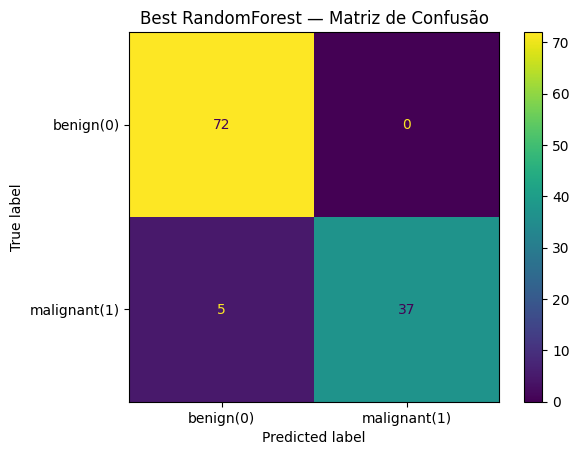

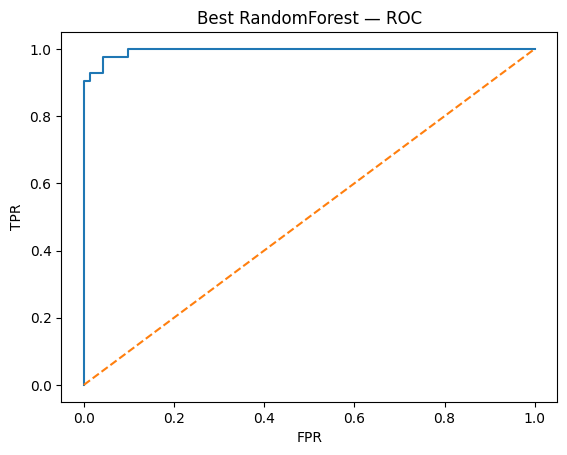

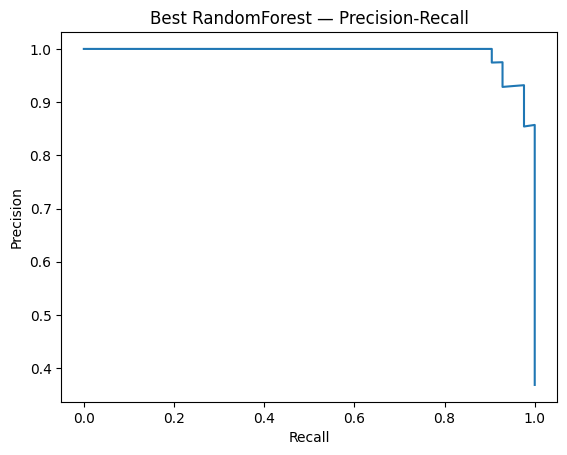

Total de erros: 5 (de 114)
[Best GradientBoosting]
Accuracy: 0.9649122807017544
Precision: 1.0
Recall: 0.9047619047619048
F1: 0.95
ROC-AUC: 0.9933862433862433
Tempo de treino (s): 1.81

Classification report:
              precision    recall  f1-score   support

   benign(0)       0.95      1.00      0.97        72
malignant(1)       1.00      0.90      0.95        42

    accuracy                           0.96       114
   macro avg       0.97      0.95      0.96       114
weighted avg       0.97      0.96      0.96       114



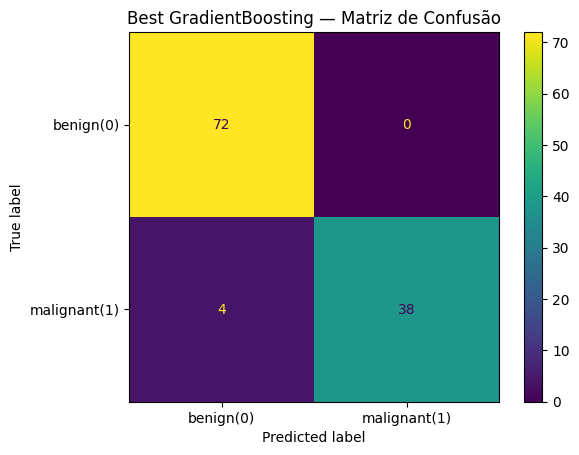

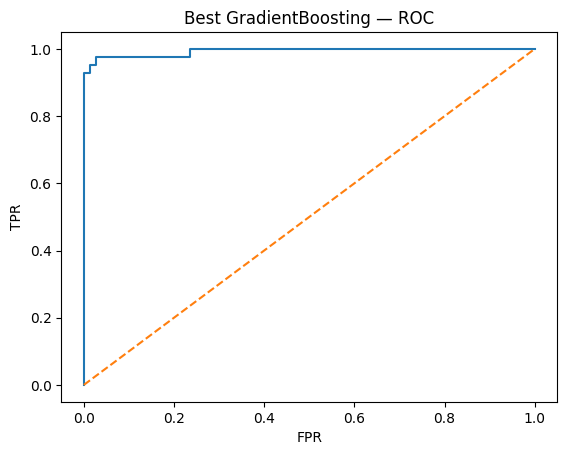

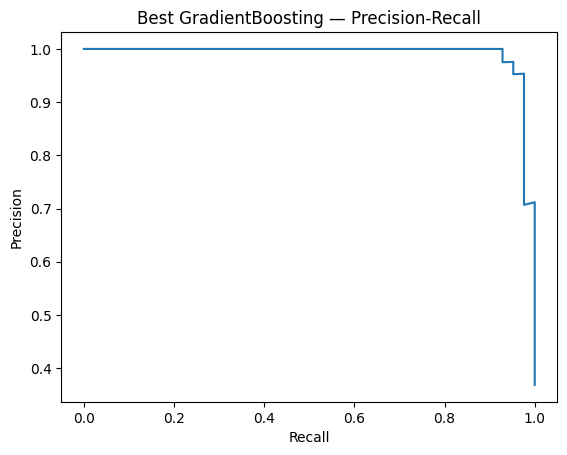

Total de erros: 4 (de 114)
[Best SVC]
Accuracy: 0.9736842105263158
Precision: 1.0
Recall: 0.9285714285714286
F1: 0.9629629629629629
ROC-AUC: 0.9957010582010581
Tempo de treino (s): 0.03

Classification report:
              precision    recall  f1-score   support

   benign(0)       0.96      1.00      0.98        72
malignant(1)       1.00      0.93      0.96        42

    accuracy                           0.97       114
   macro avg       0.98      0.96      0.97       114
weighted avg       0.97      0.97      0.97       114



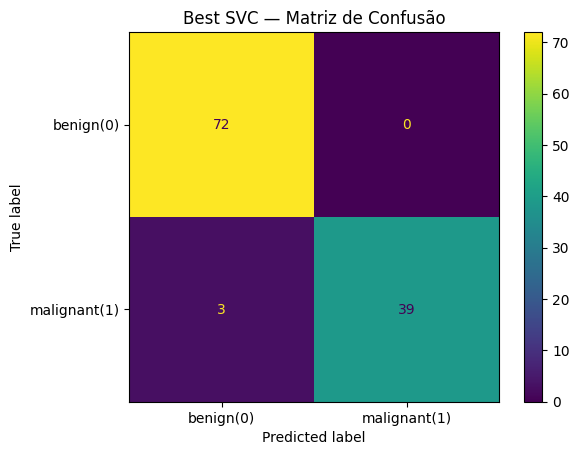

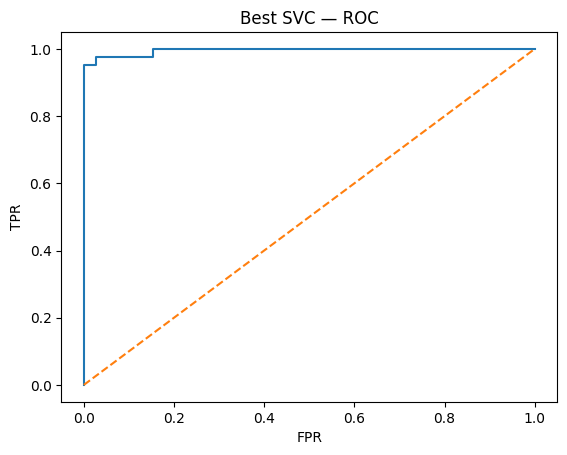

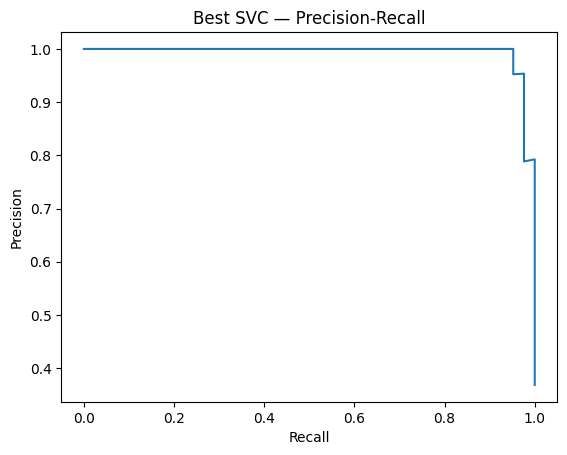

Total de erros: 3 (de 114)


In [9]:
#@title Avaliação final em TESTE + análise de erros
def evaluate_on_test(pipe, X_tr, y_tr, X_te, y_te, label="Modelo"):
    t0 = time(); pipe.fit(X_tr, y_tr); train_time = time()-t0
    y_pred = pipe.predict(X_te)
    if hasattr(pipe, "predict_proba"):
        y_proba = pipe.predict_proba(X_te)[:,1]
    elif hasattr(pipe, "decision_function"):
        y_proba = pipe.decision_function(X_te)
    else:
        y_proba = None

    print(f"[{label}]")
    print("Accuracy:", accuracy_score(y_te, y_pred))
    print("Precision:", precision_score(y_te, y_pred, zero_division=0))
    print("Recall:", recall_score(y_te, y_pred, zero_division=0))
    print("F1:", f1_score(y_te, y_pred, zero_division=0))
    if y_proba is not None:
        print("ROC-AUC:", roc_auc_score(y_te, y_proba))
    print("Tempo de treino (s):", round(train_time,2))
    print("\nClassification report:")
    print(classification_report(y_te, y_pred, target_names=["benign(0)","malignant(1)"], zero_division=0))

    cm = confusion_matrix(y_te, y_pred, labels=[0,1])
    ConfusionMatrixDisplay(cm, display_labels=["benign(0)","malignant(1)"]).plot()
    plt.title(f"{label} — Matriz de Confusão"); plt.show()

    # Curvas ROC/PR
    if y_proba is not None:
        fpr, tpr, _ = roc_curve(y_te, y_proba)
        plt.figure(); plt.plot(fpr, tpr); plt.plot([0,1],[0,1], "--")
        plt.xlabel("FPR"); plt.ylabel("TPR"); plt.title(f"{label} — ROC"); plt.show()

        prec, rec, _ = precision_recall_curve(y_te, y_proba)
        plt.figure(); plt.plot(rec, prec)
        plt.xlabel("Recall"); plt.ylabel("Precision"); plt.title(f"{label} — Precision-Recall"); plt.show()

    # Erros para inspeção rápida
    errors_idx = np.where(y_pred != y_te)[0]
    print(f"Total de erros: {len(errors_idx)} (de {len(y_te)})")
    return {"y_pred": y_pred, "proba": y_proba, "errors_idx": errors_idx}

metrics_rf  = evaluate_on_test(best_rf,  X_train, y_train, X_test, y_test, label="Best RandomForest")
metrics_gbc = evaluate_on_test(best_gbc, X_train, y_train, X_test, y_test, label="Best GradientBoosting")
metrics_svc = evaluate_on_test(best_svc, X_train, y_train, X_test, y_test, label="Best SVC")


## 9) Engenharia de Atributos (detalhe)

- **Seleção de atributos**:  
  - `SelectKBest` com **mutual information**.  
  - `SelectFromModel` usando **L1** (Logistic com `saga`) para escolher subconjunto esparso.
- **Observações**: seleção acontece **dentro** da pipeline para evitar vazamento.


In [10]:
#@title Experimentos de seleção de atributos em pipeline
kbest_lr = Pipeline([("prep", preprocess),
                     ("kbest", SelectKBest(mutual_info_classif, k=15)),
                     ("clf", LogisticRegression(max_iter=700, random_state=GLOBAL_SEED))])

sfm_rf = Pipeline([("prep", preprocess),
                   ("sfm", SelectFromModel(LogisticRegression(penalty="l1", solver="saga",
                                                              max_iter=1500, random_state=GLOBAL_SEED),
                                           max_features=20)),
                   ("clf", RandomForestClassifier(n_estimators=300, random_state=GLOBAL_SEED))])

# Avaliação rápida (CV)
rows = []
for name, pipe in [("SelectKBest+LR", kbest_lr), ("SelectFromModel(L1)+RF", sfm_rf)]:
    res = cross_validate(pipe, X_train, y_train, cv=cv, scoring={"roc_auc":"roc_auc","f1":"f1"}, n_jobs=-1)
    rows.append({"modelo": name, "roc_auc_mean": res["test_roc_auc"].mean(), "f1_mean": res["test_f1"].mean()})
pd.DataFrame(rows)


,modelo,roc_auc_mean,f1_mean
0,SelectKBest+LR,0.988442,0.921272
1,SelectFromModel(L1)+RF,0.986275,0.949736


## 10) Boas Práticas e Rastreabilidade

- **Baseline** estabelecido e comparado.  
- **Seeds** e versões registrados.  
- **Pipelines** para evitar *data leakage*.  
- Espaços de busca e melhores hiperparâmetros documentados.  
- Tempos de treino e avaliação exibidos para referência de custo computacional.


## 11) Conclusões e Próximos Passos

**Resumo dos resultados**: escolha o modelo com melhor **ROC-AUC** e bom **recall/F1** como solução principal; valide a estabilidade com CV.  
**Próximos passos**:
1. **Curvas de aprendizado e validação** para diagnóstico fino de bias/variance.  
2. **Calibração de probabilidades** e ajuste de **threshold** se recall for crítico.  
3. **Nested CV** para reduzir otimismo em *model selection*.  
4. Explorar **class weights** e custo sensível ao erro (aplicação clínica).  
5. Interpretabilidade: **importâncias** (árvores), **coeficientes** (LR) e SHAP/LIME.


# Extensões: Curvas, Calibração, Nested CV e Threshold Tuning
**Data:** 2025-09-18

Este bloco amplia o relatório com:
1. **Curvas de aprendizado** e **curvas de validação** (diagnóstico bias/variance);
2. **Calibração de probabilidades** (Platt/sigmoid e isotônica) + Brier e reliability diagrams;
3. **Nested Cross-Validation** para estimativa menos enviesada de desempenho;
4. **Class weights** e **otimização de limiar (threshold tuning)** para priorizar *recall*.


## 12) Curvas de Aprendizado & Validação (Bias/Variance)

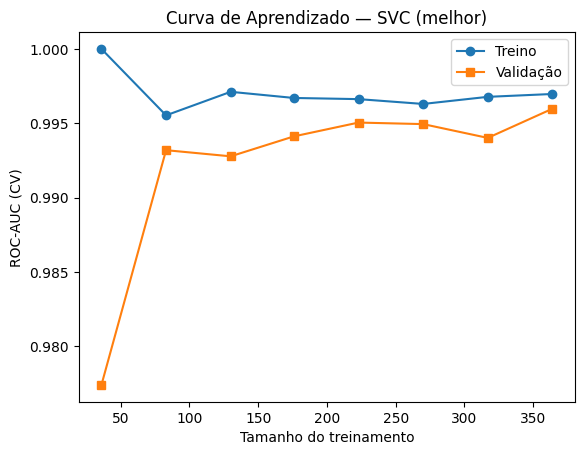

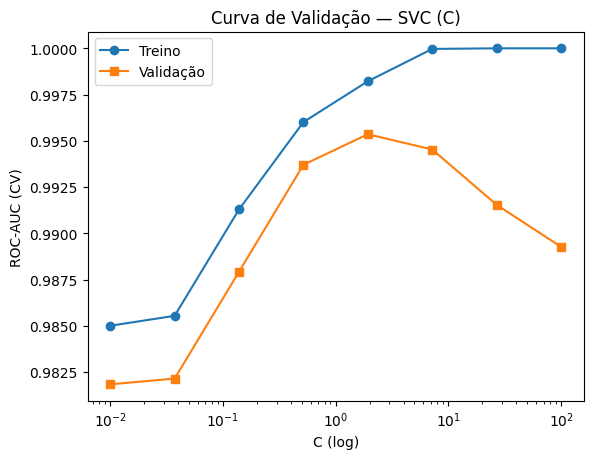

In [11]:
# Curva de aprendizado usando o melhor SVC encontrado (best_svc)
from sklearn.model_selection import learning_curve, validation_curve
import numpy as np
import matplotlib.pyplot as plt

train_sizes, train_scores, val_scores = learning_curve(
    best_svc, X_train, y_train, cv=cv, scoring="roc_auc",
    train_sizes=np.linspace(0.1, 1.0, 8), n_jobs=-1, shuffle=True, random_state=GLOBAL_SEED
)
train_mean = train_scores.mean(axis=1)
val_mean = val_scores.mean(axis=1)

plt.figure()
plt.plot(train_sizes, train_mean, marker="o", label="Treino")
plt.plot(train_sizes, val_mean, marker="s", label="Validação")
plt.xlabel("Tamanho do treinamento"); plt.ylabel("ROC-AUC (CV)")
plt.title("Curva de Aprendizado — SVC (melhor)"); plt.legend(); plt.show()

# Curva de validação para SVC — hiperparâmetro C
param_range = np.logspace(-2, 2, 8)
val_train_scores, val_test_scores = validation_curve(
    Pipeline([("prep", preprocess), ("clf", SVC(kernel="rbf", probability=True, random_state=GLOBAL_SEED))]),
    X_train, y_train, param_name="clf__C", param_range=param_range,
    cv=cv, scoring="roc_auc", n_jobs=-1
)

plt.figure()
plt.semilogx(param_range, val_train_scores.mean(axis=1), marker="o", label="Treino")
plt.semilogx(param_range, val_test_scores.mean(axis=1), marker="s", label="Validação")
plt.xlabel("C (log)"); plt.ylabel("ROC-AUC (CV)")
plt.title("Curva de Validação — SVC (C)"); plt.legend(); plt.show()


## 13) Calibração de Probabilidades (Platt vs. Isotônica)

SVC não calibrado — Brier score: 0.0137


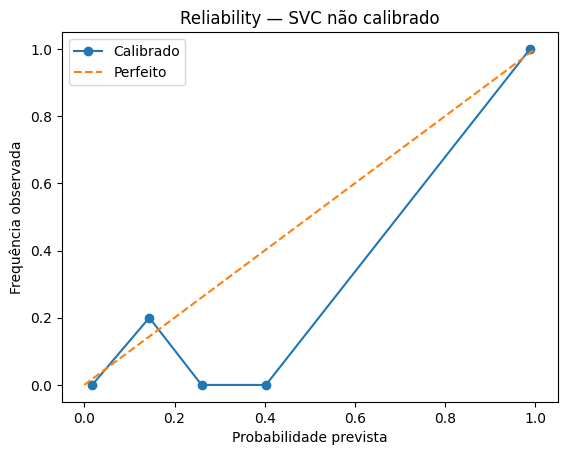

SVC calibrado (sigmoid) — Brier score: 0.0273


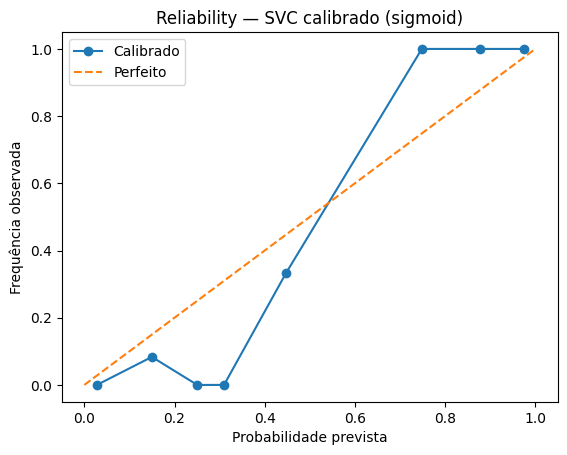

SVC calibrado (isotônica) — Brier score: 0.026


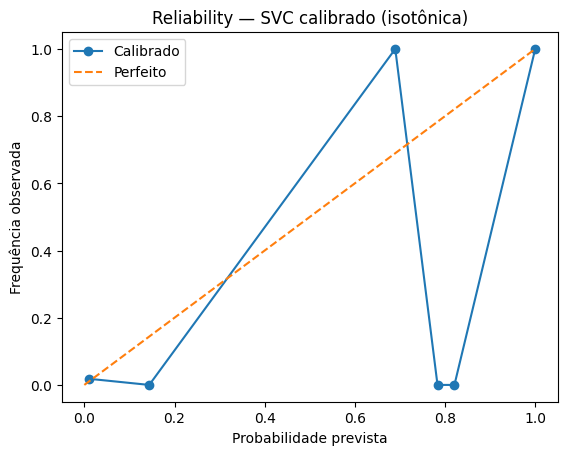

In [12]:
# Calibração de probabilidades para o melhor SVC
from sklearn.calibration import CalibratedClassifierCV, calibration_curve
from sklearn.metrics import brier_score_loss
from sklearn.model_selection import train_test_split

svc_uncal = best_svc

# Holdout interno a partir do treino para avaliar calibração
X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=GLOBAL_SEED
)

cal_sig = CalibratedClassifierCV(svc_uncal, method="sigmoid", cv=5)
cal_iso = CalibratedClassifierCV(svc_uncal, method="isotonic", cv=5)

cal_sig.fit(X_tr, y_tr)
cal_iso.fit(X_tr, y_tr)

p_uncal = svc_uncal.predict_proba(X_val)[:,1]
p_sig   = cal_sig.predict_proba(X_val)[:,1]
p_iso   = cal_iso.predict_proba(X_val)[:,1]

def reliability_plot(y_true, probas, title):
    frac_pos, mean_pred = calibration_curve(y_true, probas, n_bins=10, strategy="uniform")
    import matplotlib.pyplot as plt
    plt.figure()
    plt.plot(mean_pred, frac_pos, marker="o", label="Calibrado")
    plt.plot([0,1],[0,1],"--", label="Perfeito")
    plt.xlabel("Probabilidade prevista"); plt.ylabel("Frequência observada")
    plt.title(title); plt.legend(); plt.show()

for name, p in [("SVC não calibrado", p_uncal),
                ("SVC calibrado (sigmoid)", p_sig),
                ("SVC calibrado (isotônica)", p_iso)]:
    print(f"{name} — Brier score:", round(brier_score_loss(y_val, p), 4))
    reliability_plot(y_val, p, f"Reliability — {name}")


## 14) Nested Cross-Validation (estimativa menos enviesada)

In [13]:
# Nested CV com RandomForest (ROC-AUC)
from sklearn.model_selection import StratifiedKFold, RandomizedSearchCV
import numpy as np, time

outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=GLOBAL_SEED)
inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=GLOBAL_SEED)

rf_pipe = Pipeline([("prep", preprocess),
                    ("clf", RandomForestClassifier(random_state=GLOBAL_SEED))])

rf_space_nested = {
    "clf__n_estimators": [100,200,300,500],
    "clf__max_depth": [None,3,5,7,10],
    "clf__min_samples_split": [2,5,10],
    "clf__min_samples_leaf": [1,2,4],
    "clf__max_features": ["sqrt","log2", None],
}

search = RandomizedSearchCV(rf_pipe, rf_space_nested, n_iter=20, scoring="roc_auc",
                            refit=True, cv=inner, random_state=GLOBAL_SEED, n_jobs=-1)

outer_scores = []
t0 = time.time()
for i, (tr_idx, te_idx) in enumerate(outer.split(X, y)):
    X_tr_o, X_te_o = X.iloc[tr_idx], X.iloc[te_idx]
    y_tr_o, y_te_o = y.iloc[tr_idx], y.iloc[te_idx]
    search.fit(X_tr_o, y_tr_o)
    best = search.best_estimator_
    proba = best.predict_proba(X_te_o)[:,1]
    score = roc_auc_score(y_te_o, proba)
    outer_scores.append(score)
    print(f"Fold externo {i+1}: ROC-AUC={score:.4f} | best_params={search.best_params_}")

print(f"Nested CV — ROC-AUC: {np.mean(outer_scores):.4f} ± {np.std(outer_scores):.4f}")
print(f"Tempo total (s): {time.time()-t0:.1f}")


Fold externo 1: ROC-AUC=0.9987 | best_params={'clf__n_estimators': 500, 'clf__min_samples_split': 5, 'clf__min_samples_leaf': 2, 'clf__max_features': 'log2', 'clf__max_depth': None}
Fold externo 2: ROC-AUC=0.9784 | best_params={'clf__n_estimators': 200, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 2, 'clf__max_features': 'sqrt', 'clf__max_depth': 5}
Fold externo 3: ROC-AUC=0.9921 | best_params={'clf__n_estimators': 200, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 1, 'clf__max_features': 'log2', 'clf__max_depth': 10}
Fold externo 4: ROC-AUC=0.9969 | best_params={'clf__n_estimators': 500, 'clf__min_samples_split': 2, 'clf__min_samples_leaf': 1, 'clf__max_features': None, 'clf__max_depth': None}
Fold externo 5: ROC-AUC=0.9920 | best_params={'clf__n_estimators': 100, 'clf__min_samples_split': 10, 'clf__min_samples_leaf': 2, 'clf__max_features': 'log2', 'clf__max_depth': 5}
Nested CV — ROC-AUC: 0.9916 ± 0.0071
Tempo total (s): 289.7


## 15) Class Weights & Threshold Tuning (priorizando Recall)

In [14]:
# Comparar class_weight e ajustar threshold para atingir recall alvo
from sklearn.base import clone
from sklearn.metrics import precision_recall_curve, accuracy_score, precision_score, recall_score, f1_score, roc_auc_score

svc_bal = Pipeline([("prep", preprocess),
                    ("clf", SVC(kernel="rbf", probability=True, class_weight="balanced", random_state=GLOBAL_SEED))])

lr_bal = Pipeline([("prep", preprocess),
                   ("clf", LogisticRegression(max_iter=1000, class_weight="balanced", random_state=GLOBAL_SEED))])

models_cmp = {
    "SVC (best, sem weights)": best_svc,
    "SVC (balanced)": svc_bal,
    "LogisticRegression (balanced)": lr_bal,
}

rows = []
for name, mdl in models_cmp.items():
    m = clone(mdl).fit(X_train, y_train)
    proba = m.predict_proba(X_test)[:,1]
    pred  = (proba >= 0.5).astype(int)
    rows.append({
        "model": name,
        "roc_auc": roc_auc_score(y_test, proba),
        "accuracy": accuracy_score(y_test, pred),
        "precision": precision_score(y_test, pred, zero_division=0),
        "recall": recall_score(y_test, pred, zero_division=0),
        "f1": f1_score(y_test, pred, zero_division=0)
    })
pd.DataFrame(rows).sort_values("roc_auc", ascending=False)


,model,roc_auc,accuracy,precision,recall,f1
0,"SVC (best, sem weights)",0.995701,0.973684,1.00000,0.928571,0.962963
1,SVC (balanced),0.995370,0.982456,0.97619,0.976190,0.976190
2,LogisticRegression (balanced),0.995370,0.973684,0.97561,0.952381,0.963855


Threshold escolhido para recall ≥ 0.95: 0.4871
Métricas em TESTE (threshold ajustado):
  ROC-AUC: 0.9950396825396826
  Accuracy: 0.9736842105263158
  Precision: 0.9534883720930233
  Recall: 0.9761904761904762
  F1: 0.9647058823529412


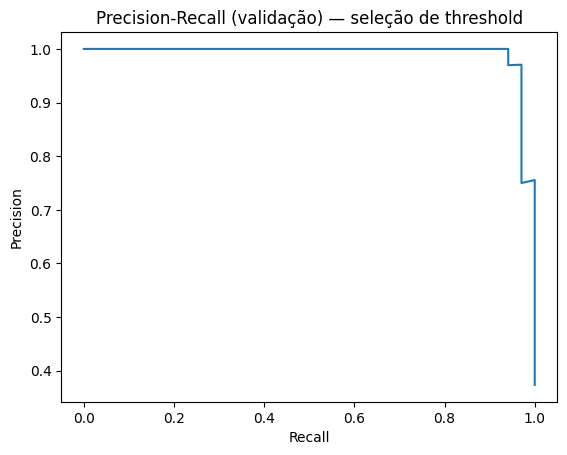

In [15]:
# Tuning de threshold visando recall mínimo
desired_recall = 0.95  # ajuste conforme necessidade do domínio

X_tr, X_val, y_tr, y_val = train_test_split(
    X_train, y_train, test_size=0.2, stratify=y_train, random_state=GLOBAL_SEED
)
mdl = clone(best_svc).fit(X_tr, y_tr)
val_proba = mdl.predict_proba(X_val)[:,1]

prec, rec, thr = precision_recall_curve(y_val, val_proba)

cands = [(thr[i], prec[i], rec[i]) for i in range(len(thr)) if rec[i] >= desired_recall]
if cands:
    # Escolhe threshold que maximiza precisão dado recall mínimo
    tuned_threshold = sorted(cands, key=lambda x: (-x[1], x[0]))[0][0]
else:
    tuned_threshold = 0.5  # fallback

print(f"Threshold escolhido para recall ≥ {desired_recall}: {tuned_threshold:.4f}")

# Avaliar no TESTE com threshold ajustado
test_proba = mdl.predict_proba(X_test)[:,1]
test_pred_tuned = (test_proba >= tuned_threshold).astype(int)

print("Métricas em TESTE (threshold ajustado):")
print("  ROC-AUC:", roc_auc_score(y_test, test_proba))
print("  Accuracy:", accuracy_score(y_test, test_pred_tuned))
print("  Precision:", precision_score(y_test, test_pred_tuned, zero_division=0))
print("  Recall:", recall_score(y_test, test_pred_tuned, zero_division=0))
print("  F1:", f1_score(y_test, test_pred_tuned, zero_division=0))

# Visualizar trade-off (validação)
plt.figure()
plt.plot(rec, prec)
plt.xlabel("Recall"); plt.ylabel("Precision")
plt.title("Precision-Recall (validação) — seleção de threshold")
plt.show()
